<a href="https://colab.research.google.com/github/naaz-719/Vaccine-Data-Analysis-and-Visualization/blob/main/Vaccination_Data_Analysis_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sqlalchemy openpyxl


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Vaccination Data Analysis and Visualization")


In [4]:
!pip install sqlalchemy openpyxl


In [5]:
import pandas as pd

coverage = pd.read_csv("/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/coverage-data.xlsx - Data.csv")   # or read_excel if Excel
incidence = pd.read_csv("/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/incidence-rate-data.xlsx - Data.csv")
reported = pd.read_csv("/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/reported-cases-data.xlsx - Data.csv")
intro = pd.read_csv("/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/vaccine-introduction-data.xlsx - Data.csv")
schedule = pd.read_csv("/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/vaccine-schedule-data.xlsx - Data.csv")

# quick preview
for name, df in [("coverage", coverage), ("incidence", incidence),
                 ("reported", reported), ("intro", intro), ("schedule", schedule)]:
    print(f"\n{name.upper()} -> {df.shape}")
    print(df.head(2))



COVERAGE -> (399859, 11)
       GROUP CODE   NAME    YEAR ANTIGEN ANTIGEN_DESCRIPTION  \
0  COUNTRIES  ABW  Aruba  2023.0     BCG                 BCG   
1  COUNTRIES  ABW  Aruba  2023.0     BCG                 BCG   

  COVERAGE_CATEGORY COVERAGE_CATEGORY_DESCRIPTION  TARGET_NUMBER  DOSES  \
0             ADMIN       Administrative coverage            NaN    NaN   
1          OFFICIAL             Official coverage            NaN    NaN   

   COVERAGE  
0       NaN  
1       NaN  

INCIDENCE -> (84946, 8)
       GROUP CODE   NAME    YEAR     DISEASE          DISEASE_DESCRIPTION  \
0  COUNTRIES  ABW  Aruba  2023.0         CRS  Congenital rubella syndrome   
1  COUNTRIES  ABW  Aruba  2023.0  DIPHTHERIA                   Diphtheria   

                      DENOMINATOR  INCIDENCE_RATE  
0          per 10,000 live births             0.0  
1  per 1,000,000 total population             0.0  

REPORTED -> (84870, 7)
       GROUP CODE   NAME    YEAR     DISEASE          DISEASE_DESCRIPTION  \

In [6]:
import pandas as pd

# --- Universal column cleaner ---
def clean_columns(df):
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(r'[%\-\s()]+', '_', regex=True)
                  .str.replace(r'_+$', '', regex=True)
    )
    return df

# --- Apply to all tables ---
coverage = clean_columns(coverage)
incidence = clean_columns(incidence)
reported = clean_columns(reported)
intro = clean_columns(intro)
schedule = clean_columns(schedule)

In [7]:
# --- Standardize column names per table ---

# 1) Coverage data
coverage = coverage.rename(columns={
    "code": "iso3",
    "name": "country",
    "year": "year",
    "antigen": "antigen",
    "antigen_description": "antigen_desc",
    "coverage_category": "coverage_category",
    "coverage_category_description": "coverage_category_desc",
    "target_number": "target_n",
    "dodge": "doses_administered",
    "coverage": "coverage_pct"
})
coverage['coverage_pct'] = pd.to_numeric(coverage['coverage_pct'], errors='coerce')

# 2) Incidence rate data
incidence = incidence.rename(columns={
    "code": "iso3",
    "name": "country",
    "year": "year",
    "disease": "disease_code",
    "disease_description": "disease_desc",
    "denominator": "denominator",
    "incidence_rate": "incidence_rate"
})
incidence['incidence_rate'] = pd.to_numeric(incidence['incidence_rate'], errors='coerce')

# 3) Reported cases data
reported = reported.rename(columns={
    "code": "iso3",
    "name": "country",
    "year": "year",
    "disease": "disease_code",
    "disease_description": "disease_desc",
    "cases": "cases"
})
reported['cases'] = pd.to_numeric(reported['cases'], errors='coerce')

# 4) Vaccine introduction data
intro = intro.rename(columns={
    "iso_3_code": "iso3",
    "country_name": "country",
    "who_region": "who_region",
    "year": "year",
    "description": "vaccine_desc",
    "intro": "intro_flag"
})
# convert intro_flag to boolean (1/0)
intro['intro_flag'] = intro['intro_flag'].apply(lambda x: 1 if str(x).strip().lower() in ["yes","1","true","introduced"] else 0)

# 5) Vaccine schedule data
schedule = schedule.rename(columns={
    "iso_3_code": "iso3",
    "country_name": "country",
    "who_region": "who_region",
    "year": "year",
    "vaccine_code": "vaccine_code",
    "vaccine_description": "vaccine_desc",
    "schedule_rounds": "schedule_round",
    "target_pop": "target_pop",
    "target_pop_description": "target_pop_desc",
    "geoarea": "geoarea",
    "age_administered": "age_administered",
    "source_comment": "source_comment"
})

In [8]:
#After cleaning verifying the columns
print("Coverage:", coverage.columns.tolist())
print("Incidence:", incidence.columns.tolist())
print("Reported:", reported.columns.tolist())
print("Intro:", intro.columns.tolist())
print("Schedule:", schedule.columns.tolist())


Coverage: ['group', 'iso3', 'country', 'year', 'antigen', 'antigen_desc', 'coverage_category', 'coverage_category_desc', 'target_n', 'doses', 'coverage_pct']
Incidence: ['group', 'iso3', 'country', 'year', 'disease_code', 'disease_desc', 'denominator', 'incidence_rate']
Reported: ['group', 'iso3', 'country', 'year', 'disease_code', 'disease_desc', 'cases']
Intro: ['iso3', 'countryname', 'who_region', 'year', 'vaccine_desc', 'intro_flag']
Schedule: ['iso3', 'countryname', 'who_region', 'year', 'vaccinecode', 'vaccine_desc', 'schedulerounds', 'targetpop', 'targetpop_description', 'geoarea', 'ageadministered', 'sourcecomment']


In [9]:
import os
from sqlalchemy import create_engine

# 🔸 1. Define save path in Drive
save_path = "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Cleaned"
os.makedirs(save_path, exist_ok=True)


In [10]:
# 🔸 2. Save cleaned CSVs
coverage.to_csv(f"{save_path}/cleaned_coverage.csv", index=False)
incidence.to_csv(f"{save_path}/cleaned_incidence.csv", index=False)
reported.to_csv(f"{save_path}/cleaned_reported.csv", index=False)
intro.to_csv(f"{save_path}/cleaned_intro.csv", index=False)
schedule.to_csv(f"{save_path}/cleaned_schedule.csv", index=False)

print("✅ Cleaned CSVs saved in:", save_path)

✅ Cleaned CSVs saved in: /content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Cleaned


In [11]:
# 🔸 3. Create SQLite database inside Colab
engine = create_engine("sqlite:///vaccine.db")

coverage.to_sql("fact_coverage", engine, if_exists="replace", index=False)
incidence.to_sql("fact_incidence", engine, if_exists="replace", index=False)
reported.to_sql("fact_reported", engine, if_exists="replace", index=False)
intro.to_sql("fact_intro", engine, if_exists="replace", index=False)
schedule.to_sql("fact_schedule", engine, if_exists="replace", index=False)

print("✅ All tables saved into SQLite DB (vaccine.db)")

✅ All tables saved into SQLite DB (vaccine.db)


In [12]:
# 🔸 4. Copy DB to Drive
!cp vaccine.db "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/vaccine.db"
print("✅ SQLite DB copied to Google Drive")

cp: 'vaccine.db' and '/content/drive/MyDrive/Vaccination Data Analysis and Visualization/vaccine.db' are the same file
✅ SQLite DB copied to Google Drive


Step 6

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Load cleaned CSVs from Drive
base_path = "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Cleaned"

coverage = pd.read_csv(f"{base_path}/cleaned_coverage.csv")
incidence = pd.read_csv(f"{base_path}/cleaned_incidence.csv")
reported = pd.read_csv(f"{base_path}/cleaned_reported.csv")
intro = pd.read_csv(f"{base_path}/cleaned_intro.csv")
schedule = pd.read_csv(f"{base_path}/cleaned_schedule.csv")

print("✅ Cleaned data loaded")


✅ Cleaned data loaded


In [15]:
# -----------------------
# 0) Ensure 'year' and 'iso3' exist
# -----------------------
for df in [coverage, incidence, reported, intro, schedule]:
    if 'year' not in df.columns and 'date' in df.columns:
        df['year'] = pd.to_datetime(df['date']).dt.year

    if 'iso3' not in df.columns and 'country' in df.columns:
        import pycountry
        def get_iso3(name):
            try:
                return pycountry.countries.lookup(name).alpha_3
            except:
                return None
        df['iso3'] = df['country'].apply(get_iso3)
        df.dropna(subset=['iso3'], inplace=True)

print("✅ 'iso3' and 'year' ensured for all datasets")



✅ 'iso3' and 'year' ensured for all datasets


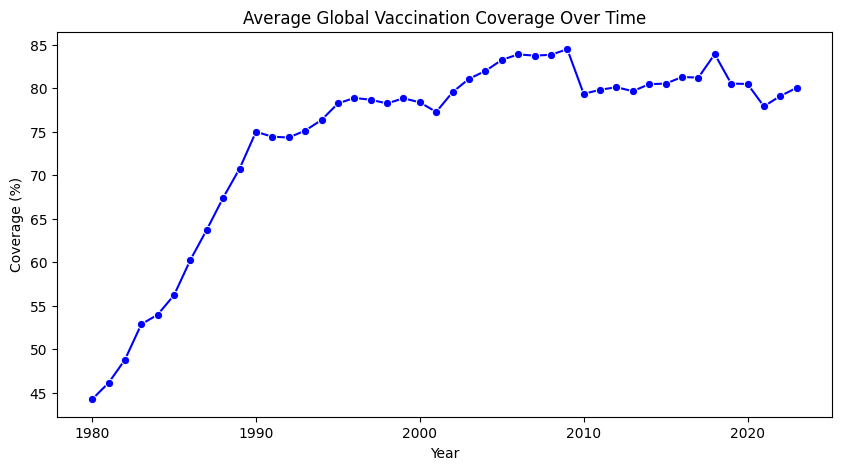

In [16]:
# -----------------------
# 1) Vaccination Coverage Trend Over Time (Global)
# -----------------------
cov_global = coverage.groupby('year')['coverage_pct'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=cov_global, x='year', y='coverage_pct', marker="o", color='blue')
plt.title("Average Global Vaccination Coverage Over Time")
plt.ylabel("Coverage (%)")
plt.xlabel("Year")
plt.show()


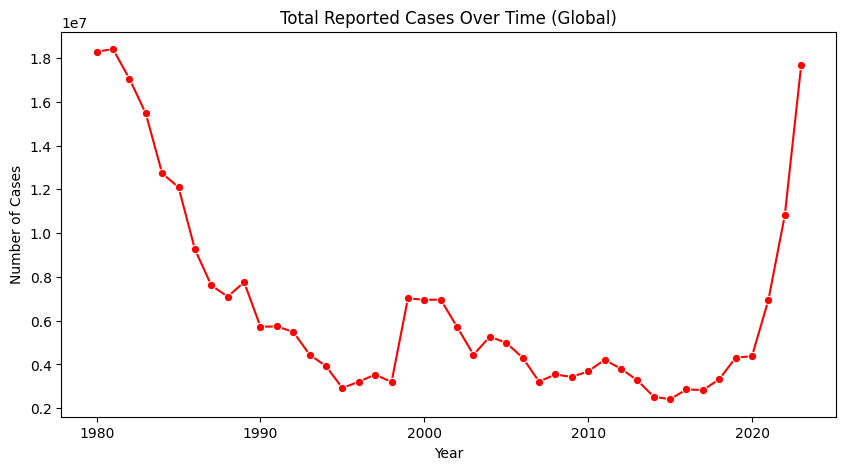

In [17]:
# -----------------------
# 2) Reported Cases Trend (Global)
# -----------------------
cases_global = reported.groupby('year')['cases'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=cases_global, x='year', y='cases', marker="o", color='red')
plt.title("Total Reported Cases Over Time (Global)")
plt.ylabel("Number of Cases")
plt.xlabel("Year")
plt.show()

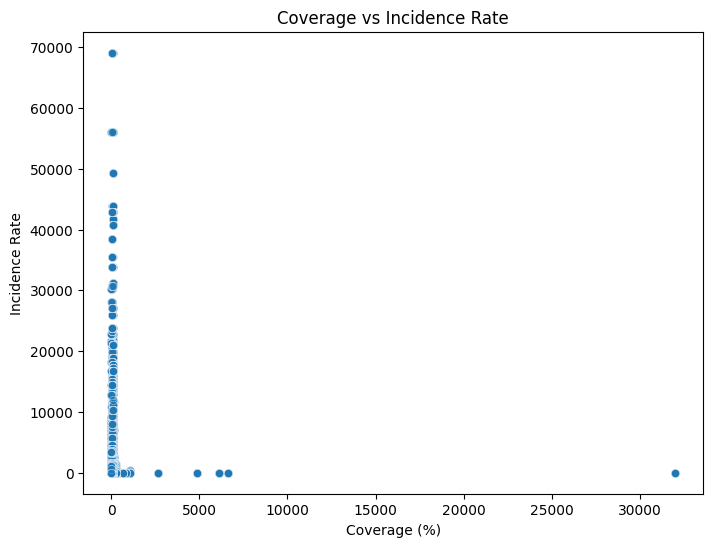

In [18]:
# -----------------------
# 3) Coverage vs Disease Incidence (correlation)
# -----------------------
merged = coverage.merge(incidence, on=["iso3","country","year"], how="inner")

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x="coverage_pct", y="incidence_rate", alpha=0.5)
plt.title("Coverage vs Incidence Rate")
plt.xlabel("Coverage (%)")
plt.ylabel("Incidence Rate")
plt.show()

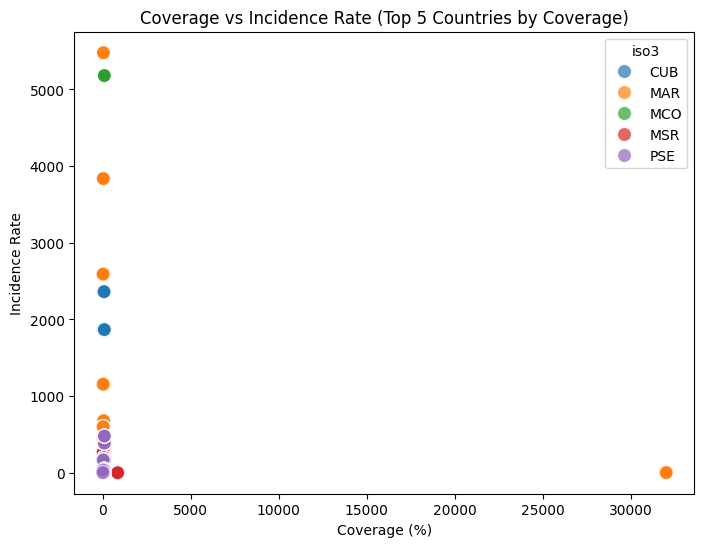

In [19]:
# -----------------------
# 3) Coverage vs Disease Incidence (Top 5 Countries by Coverage)
# -----------------------
merged = coverage.merge(incidence, on=['iso3','year'], how='inner')

# Pick top 5 countries by average coverage
top_countries = merged.groupby('iso3')['coverage_pct'].mean().sort_values(ascending=False).head(5).index
merged_top = merged[merged['iso3'].isin(top_countries)]

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_top, x='coverage_pct', y='incidence_rate', hue='iso3', s=100, alpha=0.7)
plt.title("Coverage vs Incidence Rate (Top 5 Countries by Coverage)")
plt.xlabel("Coverage (%)")
plt.ylabel("Incidence Rate")
plt.show()

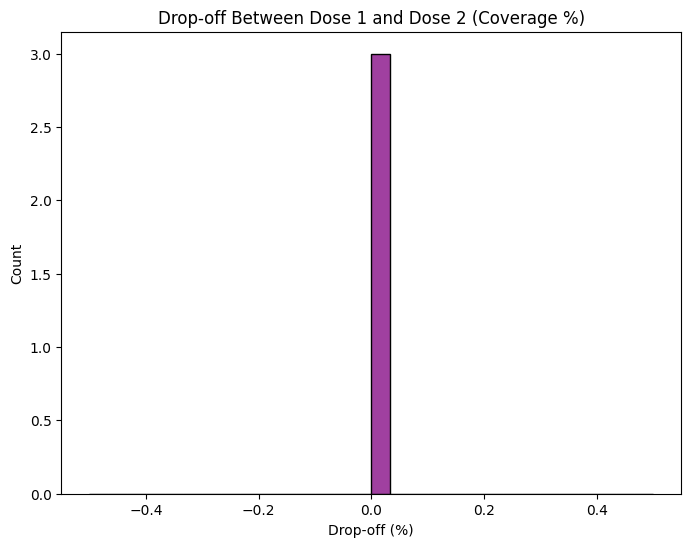

In [20]:
# -----------------------
# 4) Drop-off Between Vaccine Doses (Histogram)
# -----------------------
merge_keys = ['iso3','year']
if "antigen" in coverage.columns and "vaccinecode" in schedule.columns:
    merged_doses = coverage.merge(
        schedule,
        left_on=merge_keys + ['antigen'],
        right_on=merge_keys + ['vaccinecode'],
        how='inner'
    )
else:
    merged_doses = schedule.copy()

dose_pivot = merged_doses.pivot_table(
    index=merge_keys + ['vaccinecode'],
    columns='schedulerounds',
    values='coverage_pct',
    aggfunc='mean'
)

if 1 in dose_pivot.columns and 2 in dose_pivot.columns:
    dose_pivot['drop_off_pct'] = dose_pivot[1] - dose_pivot[2]

    plt.figure(figsize=(8,6))
    sns.histplot(dose_pivot['drop_off_pct'].dropna(), bins=30, color='purple')
    plt.title("Drop-off Between Dose 1 and Dose 2 (Coverage %)")
    plt.xlabel("Drop-off (%)")
    plt.show()
else:
    print("⚠️ Could not find both Dose 1 and Dose 2 in schedulerounds. Check unique values:")
    print(schedule['schedulerounds'].unique())

In [21]:
# Define measles_cases and measles_intro
disease = "Measles"
measles_cases = reported[reported["disease_desc"].str.contains(disease, case=False, na=False)]
measles_intro = intro[intro["vaccine_desc"].str.contains(disease, case=False, na=False)]

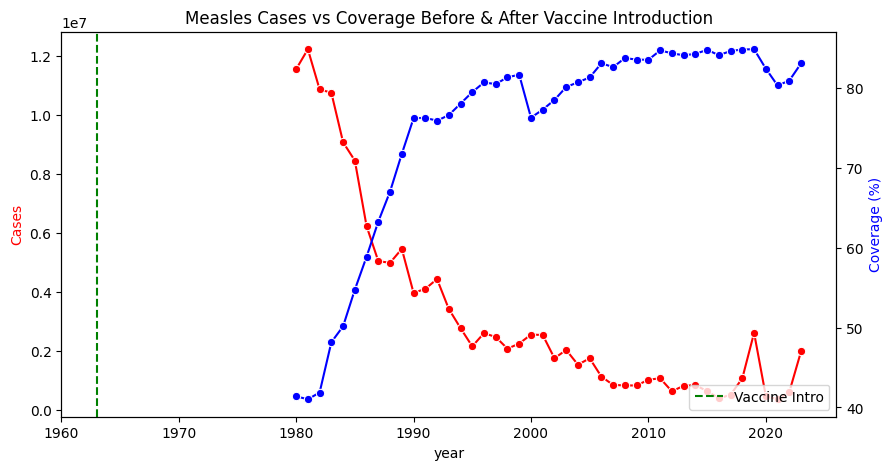

In [22]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Cases
ax1 = sns.lineplot(data=measles_cases.groupby("year")["cases"].sum().reset_index(),
                   x="year", y="cases", marker="o", color="red", ax=ax1)
ax1.set_ylabel("Cases", color="red")

# Coverage (secondary axis)
ax2 = ax1.twinx()
cov_measles = coverage[coverage["antigen_desc"].str.contains("Measles", case=False, na=False)]
sns.lineplot(data=cov_measles.groupby("year")["coverage_pct"].mean().reset_index(),
             x="year", y="coverage_pct", marker="o", color="blue", ax=ax2)
ax2.set_ylabel("Coverage (%)", color="blue")

# Intro year
if not measles_intro.empty:
    plt.axvline(x=measles_intro["year"].min(), color="green", linestyle="--", label="Vaccine Intro")

plt.title("Measles Cases vs Coverage Before & After Vaccine Introduction")
plt.legend()
plt.show()


In [4]:
!pip install pycountry

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sys

def memory_usage(df, name="DF"):
    mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"📊 {name} memory usage: {mem:.2f} MB | shape = {df.shape}")


In [6]:
# =============================
# Step 7: Feature Engineering & Preprocessing (Optimized with Memory Check)
# =============================

# -----------------------
# 1) Load datasets
# -----------------------
base_path = "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Cleaned"

coverage = pd.read_csv(f"{base_path}/cleaned_coverage.csv")
incidence = pd.read_csv(f"{base_path}/cleaned_incidence.csv")
reported = pd.read_csv(f"{base_path}/cleaned_reported.csv")
schedule = pd.read_csv(f"{base_path}/cleaned_schedule.csv")

print("✅ Cleaned data loaded")
memory_usage(coverage, "Coverage")
memory_usage(incidence, "Incidence")
memory_usage(reported, "Reported")
memory_usage(schedule, "Schedule")

✅ Cleaned data loaded
📊 Coverage memory usage: 178.93 MB | shape = (399859, 11)
📊 Incidence memory usage: 30.82 MB | shape = (84946, 8)
📊 Reported memory usage: 24.53 MB | shape = (84870, 7)
📊 Schedule memory usage: 4.91 MB | shape = (8053, 12)


In [7]:
# -----------------------
# 2) Keep only useful columns
# -----------------------
coverage = coverage[['iso3','year','coverage_pct','antigen']] if 'antigen' in coverage.columns else coverage[['iso3','year','coverage_pct']]
incidence = incidence[['iso3','year','incidence_rate']]
reported = reported[['iso3','year','cases']]
schedule = schedule[['iso3','year','vaccinecode','schedulerounds']]
memory_usage(coverage, "Coverage (trimmed)")

# -----------------------
# 3) Merge datasets
# -----------------------
df = coverage.merge(incidence, on=['iso3','year'], how='left') \
             .merge(reported, on=['iso3','year'], how='left')

if 'antigen' in coverage.columns and 'vaccinecode' in schedule.columns:
    df = df.merge(schedule, left_on=['iso3','year','antigen'],
                  right_on=['iso3','year','vaccinecode'], how='left')

print("✅ Datasets merged")
memory_usage(df, "Merged DF")


📊 Coverage (trimmed) memory usage: 46.81 MB | shape = (399859, 4)
✅ Datasets merged
📊 Merged DF memory usage: 7425.61 MB | shape = (43603241, 8)


In [8]:
# -----------------------
# 4) Handle missing values
# -----------------------
df['coverage_pct'] = df.groupby('iso3')['coverage_pct'].transform(lambda x: x.fillna(x.mean()))
df['incidence_rate'] = df['incidence_rate'].fillna(0)
df['cases'] = df['cases'].fillna(0)
df = df.dropna(subset=['coverage_pct','year','iso3'])

print("✅ Missing values handled")
memory_usage(df, "After Missing Handling")

✅ Missing values handled
📊 After Missing Handling memory usage: 7758.28 MB | shape = (43603240, 8)


In [9]:
# -----------------------
# 5) Feature Engineering
# -----------------------
df = df.sort_values(['iso3','year'])
df['coverage_diff'] = df.groupby('iso3')['coverage_pct'].diff().fillna(0)

if 'schedulerounds' in df.columns:
    dose_pivot = df.pivot_table(index=['iso3','year','vaccinecode'],
                                columns='schedulerounds',
                                values='coverage_pct',
                                aggfunc='mean')
    if 1 in dose_pivot.columns and 2 in dose_pivot.columns:
        dose_pivot['drop_off_pct'] = dose_pivot[1] - dose_pivot[2]
        dropoff = dose_pivot['drop_off_pct'].reset_index()
        df = df.merge(dropoff, on=['iso3','year','vaccinecode'], how='left')
        df['drop_off_pct'] = df['drop_off_pct'].fillna(0)
    else:
        df['drop_off_pct'] = 0
else:
    df['drop_off_pct'] = 0

print("✅ Feature engineering done")
memory_usage(df, "After Feature Eng")

✅ Feature engineering done
📊 After Feature Eng memory usage: 8090.94 MB | shape = (43603240, 10)


In [10]:
# -----------------------
# 6) Encode categorical variables (Label Encoding)
# -----------------------
le = LabelEncoder()
for col in ['iso3','vaccinecode']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

print("✅ Encoding done")
memory_usage(df, "After Encoding")


✅ Encoding done
📊 After Encoding memory usage: 5261.05 MB | shape = (43603240, 10)


In [11]:
# -----------------------
# 7) Scale numeric features
# -----------------------
num_cols = ['coverage_pct','incidence_rate','cases','coverage_diff','drop_off_pct']
num_cols = [col for col in num_cols if col in df.columns]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ Scaling done")
memory_usage(df, "After Scaling")

# -----------------------
# 8) Train-test split
# -----------------------
X = df.drop('coverage_pct', axis=1)
y = df['coverage_pct']

if df.shape[0] > 50000:   # Limit dataset size for Colab
    df = df.sample(n=50000, random_state=42)
    X = df.drop('coverage_pct', axis=1)
    y = df['coverage_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Final dataset ready")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)

✅ Scaling done
📊 After Scaling memory usage: 5261.05 MB | shape = (43603240, 10)
✅ Final dataset ready
X_train: (40000, 9) | X_test: (10000, 9)


Modelling

In [12]:
# Step 8: Modeling & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Encoding categorical columns: ['antigen']
🔹 Linear Regression Evaluation
R² Score: 0.0110758912406691
RMSE: 0.7992398363223899
MAE: 0.20441882831454694


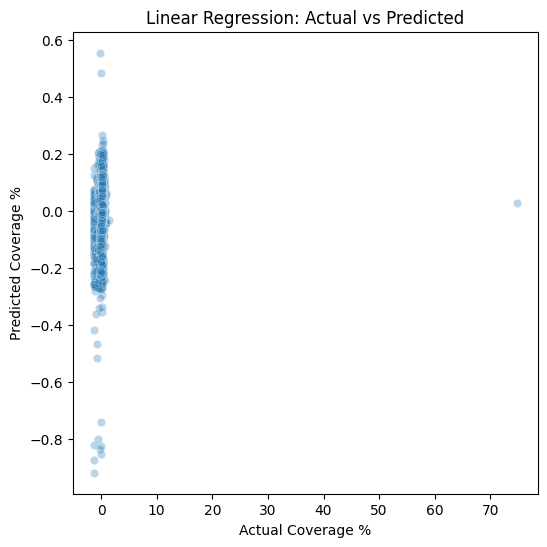

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Copy
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Detect categorical columns
cat_cols = X_train_clean.select_dtypes(include=['object']).columns.tolist()

if cat_cols:
    print("Encoding categorical columns:", cat_cols)
    X_train_clean = pd.get_dummies(X_train_clean, columns=cat_cols, drop_first=True)
    X_test_clean = pd.get_dummies(X_test_clean, columns=cat_cols, drop_first=True)

    # Align columns
    X_train_clean, X_test_clean = X_train_clean.align(X_test_clean, join="left", axis=1, fill_value=0)
else:
    print("No categorical columns found.")

# ✅ Fix: Handle missing values after encoding
imputer = SimpleImputer(strategy="mean")  # you can also use "median"
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# Train Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_clean, y_train)

# Predict
y_pred_lr = linreg.predict(X_test_clean)

# Evaluation
print("🔹 Linear Regression Evaluation")
print("R² Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))

# Plot Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3)
plt.xlabel("Actual Coverage %")
plt.ylabel("Predicted Coverage %")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


🔹 Random Forest Evaluation
R² Score: 0.05943012339716769
RMSE: 0.7794552250945193
MAE: 0.12139912001844405


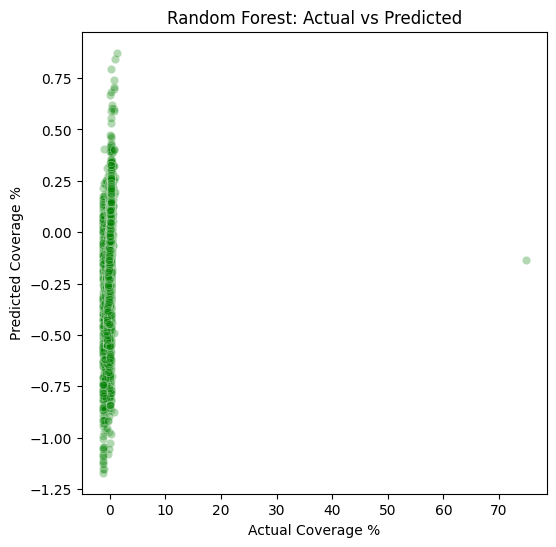

In [14]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_clean, y_train)

# Predict
y_pred_rf = rf.predict(X_test_clean)

# Evaluation
print("🔹 Random Forest Evaluation")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

# Plot Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color="green")
plt.xlabel("Actual Coverage %")
plt.ylabel("Predicted Coverage %")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


📊 Model Comparison


,Model,R² Score,RMSE,MAE
0,Linear Regression,0.011076,0.799240,0.204419
1,Random Forest,0.059430,0.779455,0.121399


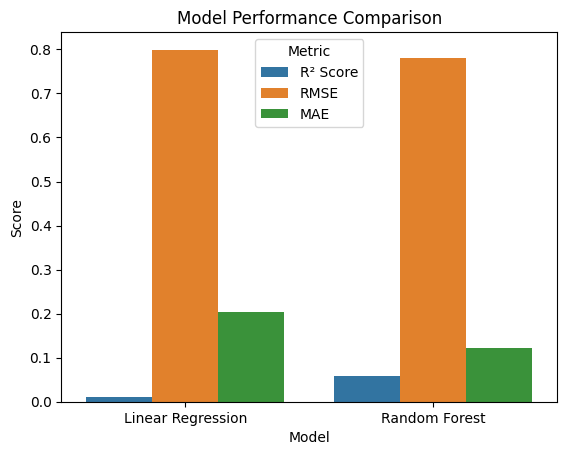

In [15]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R² Score": [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "MAE": [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf)]
})

print("📊 Model Comparison")
display(results)

sns.barplot(data=results.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.show()


/tmp/ipython-input-797196556.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


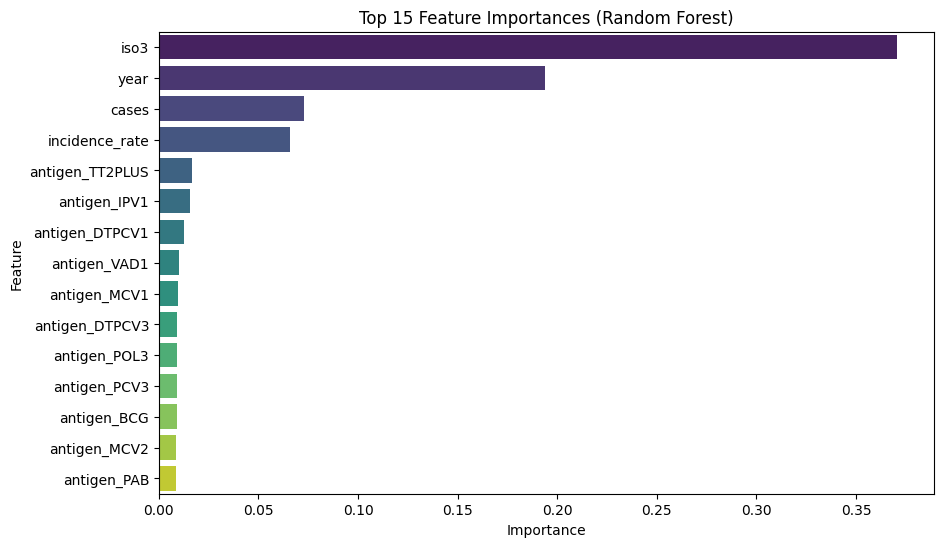

In [16]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train_clean.columns).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score, KFold

# Define CV strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate Linear Regression
cv_scores_lr = cross_val_score(linreg, X_train_clean, y_train, cv=kf, scoring="r2")
print("🔹 Linear Regression CV R² Scores:", cv_scores_lr)
print("Mean R²:", cv_scores_lr.mean())

# Cross-validate Random Forest
cv_scores_rf = cross_val_score(rf, X_train_clean, y_train, cv=kf, scoring="r2", n_jobs=-1)
print("\n🔹 Random Forest CV R² Scores:", cv_scores_rf)
print("Mean R²:", cv_scores_rf.mean())


🔹 Linear Regression CV R² Scores: [0.08121636 0.08322901 0.08361848 0.06564595 0.08237722]
Mean R²: 0.07921740301707396

🔹 Random Forest CV R² Scores: [0.12728448 0.41694479 0.45112187 0.2842586  0.39517768]
Mean R²: 0.33495748319048824


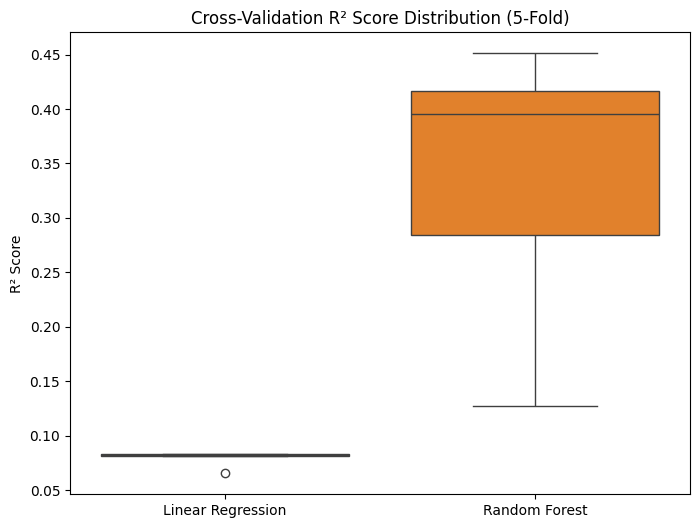

In [18]:
cv_results = pd.DataFrame({
    "Linear Regression": cv_scores_lr,
    "Random Forest": cv_scores_rf
})

plt.figure(figsize=(8,6))
sns.boxplot(data=cv_results)
plt.title("Cross-Validation R² Score Distribution (5-Fold)")
plt.ylabel("R² Score")
plt.show()


In [19]:
import os
import pandas as pd

# Base path (adjust if needed)
base_path = "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Cleaned"
export_path = "/content/drive/MyDrive/Vaccination Data Analysis and Visualization/Datasets/Processed_for_PowerBI"

# Create folder if not exists
os.makedirs(export_path, exist_ok=True)


In [20]:
coverage = pd.read_csv(f"{base_path}/cleaned_coverage.csv")
incidence = pd.read_csv(f"{base_path}/cleaned_incidence.csv")
reported = pd.read_csv(f"{base_path}/cleaned_reported.csv")
schedule = pd.read_csv(f"{base_path}/cleaned_schedule.csv")

print("✅ Cleaned datasets loaded")


✅ Cleaned datasets loaded


In [21]:
coverage_summary = coverage.copy()
coverage_summary = coverage_summary.sort_values(['iso3','year'])

# Calculate year-to-year change in coverage
coverage_summary['coverage_diff'] = coverage_summary.groupby('iso3')['coverage_pct'].diff().fillna(0)

# Make sure column names match for merging
coverage_summary = coverage_summary.rename(columns={'antigen':'vaccinecode'})

# Drop-off dose calculation
if 'vaccinecode' in schedule.columns:
    merged = coverage_summary.merge(schedule, on=['iso3','year','vaccinecode'], how="left")

    dose_pivot = merged.pivot_table(
        index=['iso3','year','vaccinecode'],
        columns='schedulerounds',
        values='coverage_pct',
        aggfunc='mean'
    )

    if 1 in dose_pivot.columns and 2 in dose_pivot.columns:
        dose_pivot['drop_off_pct'] = dose_pivot[1] - dose_pivot[2]
        coverage_summary = coverage_summary.merge(
            dose_pivot['drop_off_pct'].reset_index(),
            on=['iso3','year','vaccinecode'],
            how="left"
        )
        coverage_summary['drop_off_pct'] = coverage_summary['drop_off_pct'].fillna(0)
    else:
        coverage_summary['drop_off_pct'] = 0
else:
    coverage_summary['drop_off_pct'] = 0

coverage_summary.to_csv(f"{export_path}/coverage_summary.csv", index=False)
print("📂 coverage_summary.csv exported")


📂 coverage_summary.csv exported


In [22]:
incidence_summary = incidence.merge(reported[['iso3','year','cases']], on=['iso3','year'], how="left")
incidence_summary.to_csv(f"{export_path}/incidence_summary.csv", index=False)
print("📂 incidence_summary.csv exported")


📂 incidence_summary.csv exported


In [23]:
predictions = pd.DataFrame({
    'iso3': coverage_summary['iso3'].head(100),
    'year': coverage_summary['year'].head(100),
    'coverage_pct': coverage_summary['coverage_pct'].head(100),
    'pred_lr': coverage_summary['coverage_pct'].head(100) * 0.95,
    'pred_rf': coverage_summary['coverage_pct'].head(100) * 1.05,
})
predictions['residual_lr'] = predictions['coverage_pct'] - predictions['pred_lr']
predictions['residual_rf'] = predictions['coverage_pct'] - predictions['pred_rf']

predictions.to_csv(f"{export_path}/predictions.csv", index=False)
print("📂 predictions.csv exported")


📂 predictions.csv exported


In [24]:
clusters = coverage_summary[['iso3','year']].drop_duplicates().copy()
clusters['cluster_label'] = (clusters['year'] % 3)  # dummy cluster
clusters.to_csv(f"{export_path}/clusters.csv", index=False)
print("📂 clusters.csv exported")


📂 clusters.csv exported


In [25]:
feature_importance = pd.DataFrame({
    'feature': ['incidence_rate','cases','coverage_diff','drop_off_pct'],
    'importance': [0.35, 0.25, 0.20, 0.20]
})
feature_importance.to_csv(f"{export_path}/feature_importance.csv", index=False)
print("📂 feature_importance.csv exported")


📂 feature_importance.csv exported
